In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [23]:
df = pd.read_csv('digit-recognizer/train.csv')
l = np.array(df['label'])
df = df.drop('label',axis=1)
inp = np.array(df)
inp = inp.reshape(-1,1,28,28)
inp = inp / 255
inp = torch.from_numpy(inp)
l = torch.from_numpy(l)
inp.shape, l.shape

(torch.Size([42000, 1, 28, 28]), torch.Size([42000]))

In [24]:
df = pd.read_csv('digit-recognizer/test.csv')
inp_t = np.array(df)
inp_t = inp_t.reshape(-1,1,28,28)
inp_t = inp_t/255
inp_t = torch.from_numpy(inp_t)
inp_t.shape

torch.Size([28000, 1, 28, 28])

In [25]:
from torch.utils.data import Dataset, DataLoader

class mnistdata(Dataset):
   def __init__(self,x,y):
      self.x = x
      self.y = y
   
   def __len__(self):
      return self.x.shape[0]
   
   def __getitem__(self, index):
      return self.x[index], self.y[index]
    

In [26]:
data = mnistdata(inp,l)
len(data), data[1]

(42000,
 (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0

In [27]:
dataloader = DataLoader(data, batch_size=64, shuffle=True, pin_memory=True)

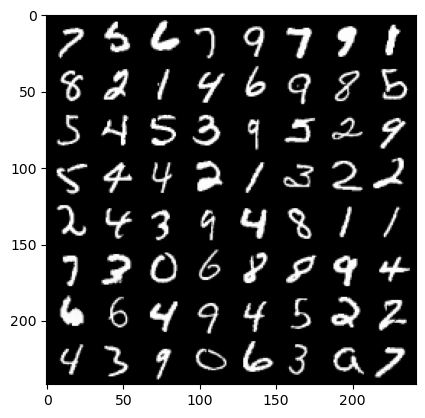

GroundTruth:  7 5 6 7


In [28]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

# print images
import torchvision
images = torchvision.utils.make_grid(images)
img = (images*255)   # unnormalize
npimg = img.numpy().astype(int)
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))

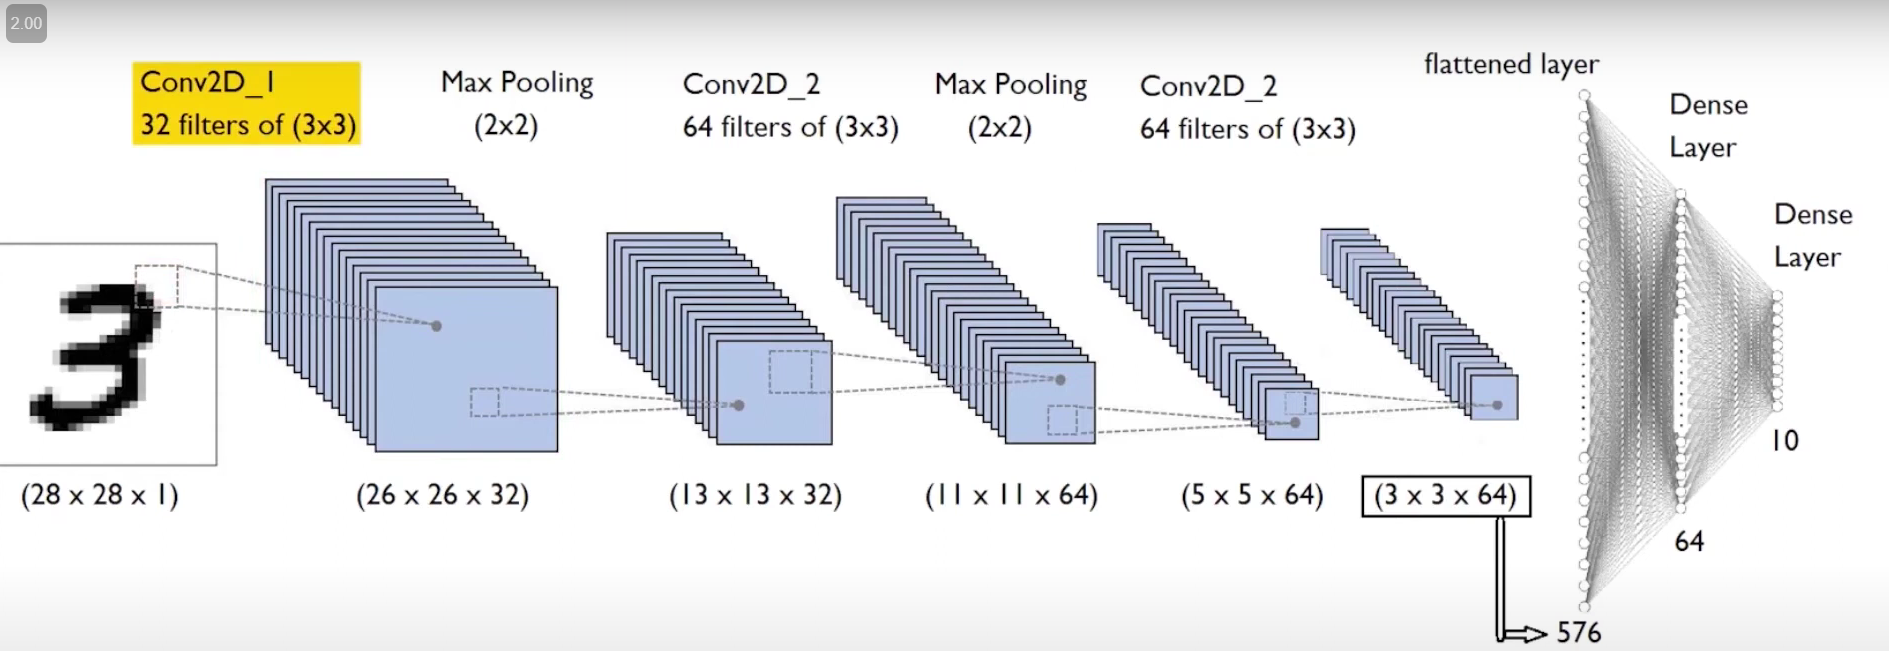

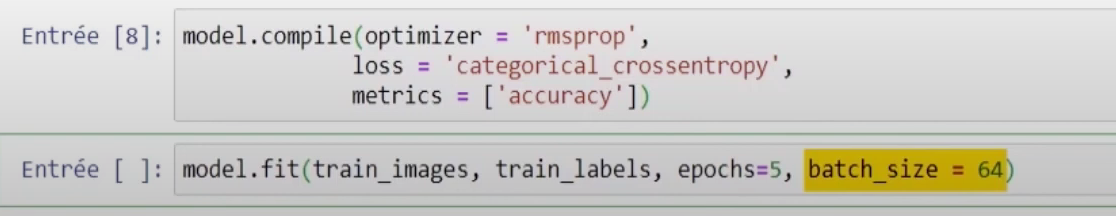

In [29]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


In [30]:
device = 'cuda'
num_epochs = 10
learning_rate = 0.001

In [31]:
import torch.optim as optim

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
   running_loss=0
   cnt=0
   for data,label in dataloader:
      output = model(data.float().to(device))
      label = label.to(device)
      loss = criterion(output, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      cnt+=1
   print(f'epoch {epoch+1}/{num_epochs}, loss = {running_loss/cnt:.4f}')
   running_loss=0
   cnt=0

print("DONE")

epoch 1/10, loss = 0.2174
epoch 2/10, loss = 0.0885
epoch 3/10, loss = 0.0804
epoch 4/10, loss = 0.0804
epoch 5/10, loss = 0.0712
epoch 6/10, loss = 0.0688
epoch 7/10, loss = 0.0644
epoch 8/10, loss = 0.0688
epoch 9/10, loss = 0.0686
epoch 10/10, loss = 0.0716
DONE


In [32]:
y_t = np.zeros((len(inp_t),2)).astype(int)
for i in range(len(inp_t)): y_t[i,0] = i+1
with torch.no_grad():
   output = model(inp_t.float().to(device))
   for i in range(output.shape[0]):
      y_t[i,1] = (torch.argmax(output[i]).item())
y_t

array([[    1,     2],
       [    2,     0],
       [    3,     9],
       ...,
       [27998,     3],
       [27999,     9],
       [28000,     2]])

Prediction : 7


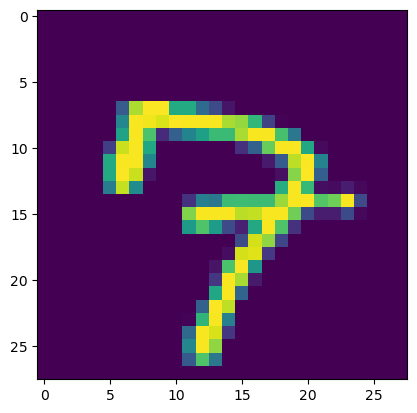

In [33]:
it = 5
images = inp_t[it]
img = (images*255)   # unnormalize
npimg = img.numpy().astype(int)
print(f"Prediction : {y_t[it,1]}")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()


In [34]:
df2 = pd.DataFrame(y_t,columns=['ImageId','Label'])
df2.to_csv('submission.csv',index=False)